# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI). Also calculates the 24-hour rainfall distribution from a set of rainfall data values for 5-minute through 24-hour durations  (see NRCS Engineering Handbook Part 630 https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=43924.wba

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. A spreadsheet with sheets for each recurrence interval that includes the NRCS nested hyetograph for the 24 hour storm.

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import precip_hyetograph_nrcs
from pyproj import Transformer

### Parameters: 

#### Papermill (site specific):

In [2]:

## Filenames and fields:
Project_Area = 'crow'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'crow_domain'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'crow_domain.shp'           # Shapefile name
filter_field = 'name'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = 'outlet'                    # Value within the filter_field used for data selection

## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [3]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h'] 
dur_names = ['5min', '10min', '15min', '30min', '60min', '2hr', '3hr', '6hr', '12hr', '24hr'] 

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.read_file(polygon_dir)

check_attributes(gdf)

gdf.head(1)

,cat,value,label,name,geometry
0,1,1,None,outlet,"POLYGON ((679816.175 4600721.004, 679816.784 4..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [11]:
print('Original Coordinate Reference System:', gdf.crs)


with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))

Original Coordinate Reference System: epsg:26918
Vector Layer crs = +proj=utm +zone=18 +datum=NAD83 +units=m +no_defs


C:\Users\cusmith\Anaconda3\envs\stable\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Extract the area of interest, reproject, and plot:

In [12]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

gdf1.crs = vector_crs_prj

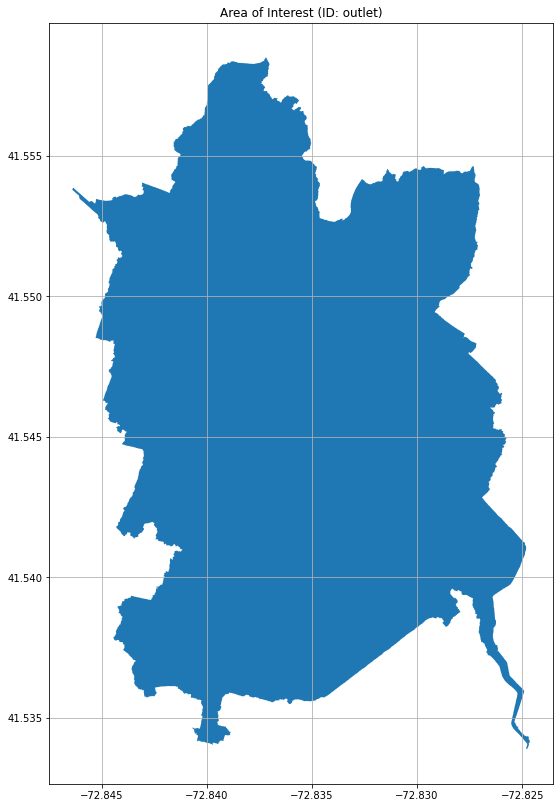

In [22]:
#Mark - issue with reprojection from NAD83 Lat lon to WGS84 Lat Lon
geo_df = gdf1.to_crs(epsg = noaa_data_crs)
#geo_df = gdf1
plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           10
Region           2
Percent_area     100.0


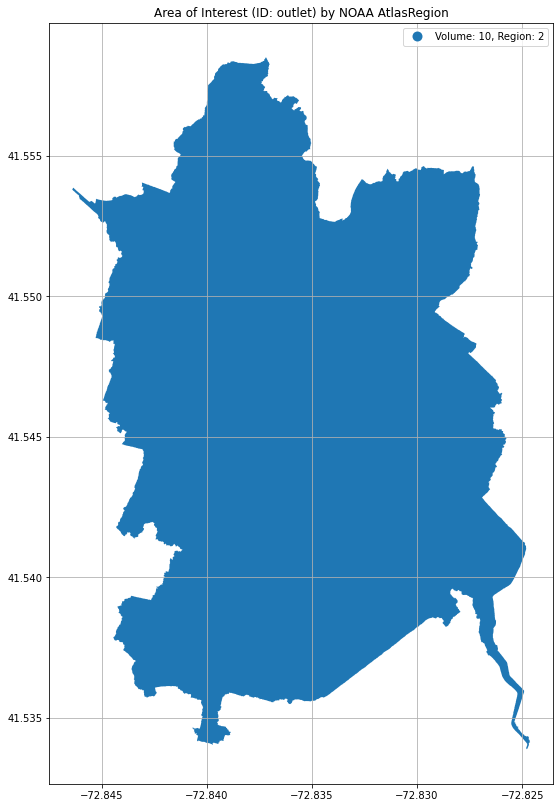

In [23]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']
#volume = '9' # Manually specify the volume if the input shapes do not overlap below

### Load Atlas 14 volume code from json:

In [24]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: ne


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [25]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    if verbose: 
        print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

30 files found for 05m
30 files found for 10m
30 files found for 15m
30 files found for 30m
30 files found for 60m
30 files found for 02h
30 files found for 03h
30 files found for 06h
30 files found for 12h
30 files found for 24h


### Iterate through zip files and build a table:

In [26]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 ne1yr05ma.zip
1 ne1yr05mal.zip
2 ne1yr05mau.zip
3 ne2yr05ma.zip
4 ne2yr05mal.zip
5 ne2yr05mau.zip
6 ne5yr05ma.zip
7 ne5yr05mal.zip
8 ne5yr05mau.zip
9 ne10yr05ma.zip
10 ne10yr05mal.zip
11 ne10yr05mau.zip
12 ne25yr05ma.zip
13 ne25yr05mal.zip
14 ne25yr05mau.zip
15 ne50yr05ma.zip
16 ne50yr05mal.zip
17 ne50yr05mau.zip
18 ne100yr05ma.zip
19 ne100yr05mal.zip
20 ne100yr05mau.zip
21 ne200yr05ma.zip
22 ne200yr05mal.zip
23 ne200yr05mau.zip
24 ne500yr05ma.zip
25 ne500yr05mal.zip
26 ne500yr05mau.zip
27 ne1000yr05ma.zip
28 ne1000yr05mal.zip
29 ne1000yr05mau.zip
30 ne1yr10ma.zip
31 ne1yr10mal.zip
32 ne1yr10mau.zip
33 ne2yr10ma.zip
34 ne2yr10mal.zip
35 ne2yr10mau.zip
36 ne5yr10ma.zip
37 ne5yr10mal.zip
38 ne5yr10mau.zip
39 ne10yr10ma.zip
40 ne10yr10mal.zip
41 ne10yr10mau.zip
42 ne25yr10ma.zip
43 ne25yr10mal.zip
44 ne25yr10mau.zip
45 ne50yr10ma.zip
46 ne50yr10mal.zip
47 ne50yr10mau.zip
48 ne100yr10ma.zip
49 ne100yr10mal.zip
50 ne100yr10mau.zip
51 ne200yr10ma.zip
52 ne200yr10mal.zip
53 ne200yr10mau.zip

,region,TR,duration,statistic,value
0,ne,1,05m,Expected Value,0.3365
1,ne,1,05m,Lower (90%),0.2630
2,ne,1,05m,Upper (90%),0.4225
3,ne,2,05m,Expected Value,0.4085
4,ne,2,05m,Lower (90%),0.3190


None


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [27]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save Precipitation Table:

In [28]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
    print(table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(filter_field) + '_' + str(select_data)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.save()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1            0.33650      0.26300      0.42250
2            0.40850      0.31900      0.51350
5            0.52650      0.40900      0.66400
10           0.62400      0.48200      0.79125
25           0.75800      0.56700      1.00950
50           0.85900      0.62975      1.17225
100          0.96475      0.68650      1.36975
200          1.08275      0.73000      1.57950
500          1.25200      0.81125      1.89750
1000         1.39000      0.87950      2.15400
      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1            0.47750      0.37250      0.59825
2            0.57875      0.45175      0.72700
5            0.74500      0.57925      0.93900
10           0.88350      0.68300      1.12000
25           1.07350      0.80325      1.43000
50           1.21650      0.89150      1.65950
100          1.36650      0.97250      1.94025
200          

,Volume,Region,Percent_area
AOI,,,
name_outlet,10,2,100.0


---

## Calculate NRCS nested hyetograph function 

In [29]:
#select events to prepare nested distribution
Return_Intervals = np.array(['2', '5', '10', '25', '50', '100', '200', '500', '1000'])  # Return intervals for calculating runoff values.


In [30]:
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
for evnt in Return_Intervals:
    precip_df = c_df.loc[evnt][['duration', 'value']].set_index('duration')
    hyetos[evnt] = precip_hyetograph_nrcs(precip_df)   

#### Plot to check behavior of 100 year recurrence interval

In [31]:
h100 = hyetos['100'].rename(columns = {'ratio':'Cumulative Distribution','t_step':'Time','slope':'100 year Distribution'}, inplace = False)

<AxesSubplot:xlabel='Time (hours)', ylabel='Precipitation (inches)'>

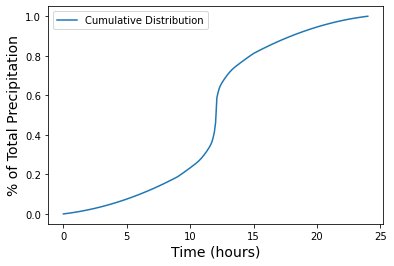

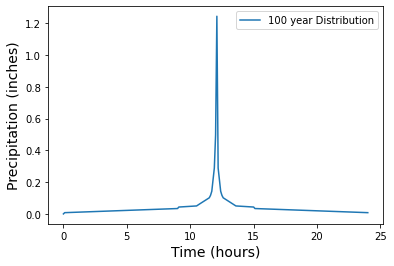

In [32]:
p1 = h100.plot('Time','Cumulative Distribution')
p1.legend()
p1.set_xlabel('Time (hours)', fontsize=14)
p1.set_ylabel('% of Total Precipitation', fontsize=14)

p2 = h100.plot('Time', '100 year Distribution')
p2.legend()
p2.set_xlabel('Time (hours)', fontsize=14)
p2.set_ylabel('Precipitation (inches)', fontsize=14)

p1
p2

### Save Nested Hyetograph:

In [33]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(c_df.index.astype(str).tolist()[1:10]):
    table = hyetos[d][['ratio', 'slope']]
    hyetos[d].to_excel(writer, sheet_name = f'nrcs_hye_{d}')
    print(table)
writer.save()

         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000430  0.004299
0.2   0.000891  0.004612
0.3   0.001384  0.004925
0.4   0.001908  0.005238
...        ...       ...
23.6  0.998092  0.005551
23.7  0.998616  0.005238
23.8  0.999109  0.004925
23.9  0.999570  0.004612
24.0  1.000000  0.004299

[241 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000574  0.005741
0.2   0.001179  0.006045
0.3   0.001814  0.006350
0.4   0.002479  0.006654
...        ...       ...
23.6  0.997521  0.006959
23.7  0.998186  0.006654
23.8  0.998821  0.006350
23.9  0.999426  0.006045
24.0  1.000000  0.005741

[241 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000650  0.006497
0.2   0.001329  0.006797
0.3   0.002039  0.007097
0.4   0.002779  0.007397
...        ...       ...
23.6  0.997221  0.007697
23.7  0.997961  0.007397
23.8  0.998671  0.007097
23.9  0.999350  0.006797
24

---